In [2]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
from keras import backend as K
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.utils import CustomObjectScope
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

In [3]:
np.random.seed(42)

# Conv Block

In [4]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

# Encoder Block

In [6]:
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

# Decoder Block

In [8]:
def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

# Build U-Net

In [10]:
def unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

model = unet((256,256,3))
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 256, 256, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_18 (Ba  (None, 256, 256, 64)         256       ['conv2d_19[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_18 (Activation)  (None, 256, 256, 64)         0         ['batch_normalization_18[0]

# Dice Loss

In [11]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

# Train the model

In [15]:
H = 256
W = 256

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
create_dir("files")

In [17]:
def load_dataset(path, split=0.2):
    images = sorted(glob(os.path.join(path, "images", "*.png")))
    masks = sorted(glob(os.path.join(path, "masks", "*.png")))

    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)
 
    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [18]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (h, w)
    x = cv2.resize(x, (W, H))   ## (h, w)
    x = x / 255.0               ## (h, w)
    x = x.astype(np.float32)    ## (h, w)
    x = np.expand_dims(x, axis=-1)## (h, w, 1)
    return x

In [19]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

In [31]:
batch_size = 16
lr = 1e-4
num_epochs = 200
model_path = os.path.join("files", "model.h5")
csv_path = os.path.join("files", "log.csv")
dataset_path="dataset2"

In [22]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

print(f"Train: ({len(train_x)},{len(train_y)})")
print(f"Valid: ({len(valid_x)},{len(valid_x)})")
print(f"Test: ({len(test_x)},{len(test_x)})")

Train: (1840,1840)
Valid: (612,612)
Test: (612,612)


In [26]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

In [38]:
model = unet((H, W, 3))
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef,'accuracy'])

In [39]:
callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
    ]

In [40]:
model.fit(
        train_dataset,
        epochs=200,
        validation_data=valid_dataset,
        callbacks=callbacks,
        verbose=1
    )

Epoch 1/200
115/115 [==============================] - ETA: 0s - loss: 0.8272 - dice_coef: 0.1728 - accuracy: 0.8844
Epoch 1: val_loss improved from inf to 0.98604, saving model to /kaggle/working/files/model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


115/115 [==============================] - 151s 977ms/step - loss: 0.8272 - dice_coef: 0.1728 - accuracy: 0.8844 - val_loss: 0.9860 - val_dice_coef: 0.0140 - val_accuracy: 0.6905 - lr: 1.0000e-04
Epoch 2/200
115/115 [==============================] - ETA: 0s - loss: 0.6675 - dice_coef: 0.3325 - accuracy: 0.9780
Epoch 2: val_loss did not improve from 0.98604
115/115 [==============================] - 104s 901ms/step - loss: 0.6675 - dice_coef: 0.3325 - accuracy: 0.9780 - val_loss: 0.9895 - val_dice_coef: 0.0104 - val_accuracy: 0.6568 - lr: 1.0000e-04
Epoch 3/200
115/115 [==============================] - ETA: 0s - loss: 0.5677 - dice_coef: 0.4323 - accuracy: 0.9845
Epoch 3: val_loss did not improve from 0.98604
115/115 [==============================] - 104s 900ms/step - loss: 0.5677 - dice_coef: 0.4323 - accuracy: 0.9845 - val_loss: 0.9892 - val_dice_coef: 0.0106 - val_accuracy: 0.8917 - lr: 1.0000e-04
Epoch 4/200
115/115 [==============================] - ETA: 0s - loss: 0.4841 - dice

## Learnig curves

In [44]:
import pandas as pd
metrics = pd.read_csv("files/model04.csv")
metrics.head(2)

,epoch,accuracy,dice_coef,loss,lr,val_accuracy,val_dice_coef,val_loss
0,0,0.884417,0.172810,0.827190,0.0001,0.690543,0.013951,0.986037
1,1,0.978028,0.332514,0.667486,0.0001,0.656845,0.010357,0.989490


# Dice_coef

<Axes: >

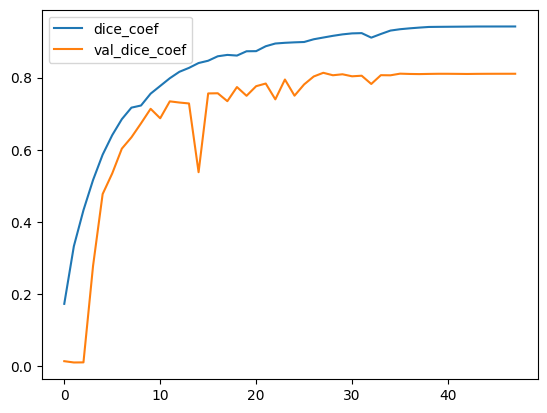

In [45]:
metrics[['dice_coef','val_dice_coef']].plot()

<Axes: >

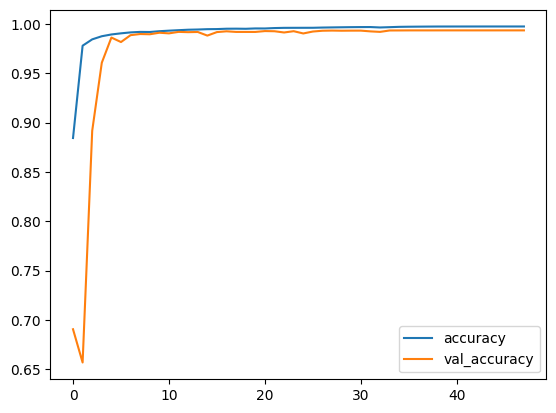

In [46]:
metrics[['accuracy','val_accuracy']].plot()

<Axes: >

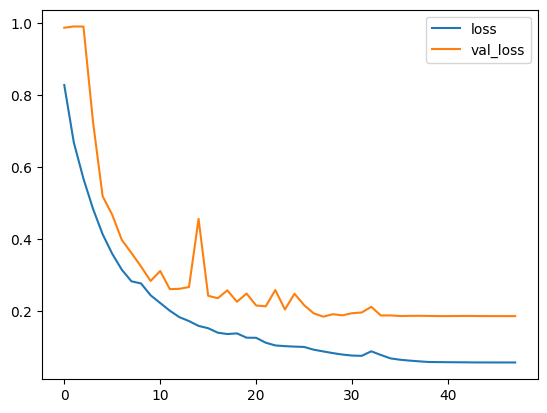

In [47]:
metrics[['loss','val_loss']].plot()